In [ ]:
# === 1. Load Dataset dan Preprocessing ===
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset

# Membaca dataset wine quality dengan delimiter yang benar (titik koma)
data = pd.read_csv('/content/winequality-red.csv', delimiter=';')

# Memeriksa beberapa baris pertama dari data untuk memastikan pemisahan kolom benar
print(data.head())

# Memisahkan fitur (X) dan label (y)
X = data.iloc[:, :-1].values  # Semua kolom kecuali kolom terakhir
y = data.iloc[:, -1].values   # Kolom terakhir (quality)

# Mengonversi y ke pandas Series untuk dapat menggunakan isnull()
y = pd.Series(y)  # Mengonversi y menjadi pandas Series

# Memastikan kolom target 'y' berisi nilai numerik
y = pd.to_numeric(y, errors='coerce')  # Mengubah kolom y ke numerik, mengganti nilai yang tidak valid dengan NaN

# Jika ada NaN, kita akan menghapus baris tersebut
if y.isnull().sum() > 0:
    print(f"Ada {y.isnull().sum()} nilai NaN dalam kolom target.")
    valid_idx = ~y.isnull()  # Indeks data yang valid
    X = X[valid_idx]
    y = y[valid_idx]

# Menampilkan beberapa nilai pertama untuk memastikan data sudah benar
print(X[:5], y[:5])

# Normalisasi fitur agar berada dalam rentang [0, 1]
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

# Membagi dataset menjadi data pelatihan (80%) dan data pengujian (20%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mengonversi y_train dan y_test menjadi float32 untuk kompatibilitas dengan PyTorch
y_train = y_train.values.astype(np.float32)  # Pastikan y_train menjadi numpy array
y_test = y_test.values.astype(np.float32)    # Pastikan y_test menjadi numpy array

# Konversi data ke Tensor PyTorch
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                               torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                              torch.tensor(y_test, dtype=torch.float32))


   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

In [ ]:
# === 2. Definisi Model MLP ===
import torch.nn as nn

class MLPRegression(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_function):
        super(MLPRegression, self).__init__()
        layers = []
        in_features = input_size

        # Menambahkan hidden layers sesuai konfigurasi
        for neurons in hidden_layers:
            layers.append(nn.Linear(in_features, neurons))  # Linear layer
            layers.append(activation_function)             # Fungsi aktivasi
            in_features = neurons

        # Output layer (linear karena regresi)
        layers.append(nn.Linear(in_features, 1))

        # Menggabungkan semua layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [ ]:
# === 3. Fungsi Aktivasi ===
def get_activation_function(name):
    if name == 'linear':
        return nn.Identity()  # Tidak ada aktivasi
    elif name == 'sigmoid':
        return nn.Sigmoid()
    elif name == 'relu':
        return nn.ReLU()
    elif name == 'tanh':
        return nn.Tanh()
    else:
        raise ValueError(f"Fungsi aktivasi '{name}' tidak dikenal.")

In [ ]:
# === 4. Fungsi Pelatihan ===
import torch.optim as optim
from torch.utils.data import DataLoader

def train_model(model, train_loader, test_loader, epochs, learning_rate):
    # Definisi optimizer dan loss function
    criterion = nn.MSELoss()  # Mean Squared Error untuk regresi
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Loop pelatihan
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()  # Set mode training
        epoch_loss = 0

        for batch in train_loader:
            inputs, targets = batch

            # Forward pass
            predictions = model(inputs).squeeze()
            loss = criterion(predictions, targets)

            # Backward pass dan optimasi
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Simpan rata-rata loss untuk epoch ini
        train_losses.append(epoch_loss / len(train_loader))

        # Evaluasi pada data uji
        model.eval()  # Set mode evaluasi
        with torch.no_grad():
            test_loss = 0
            for batch in test_loader:
                inputs, targets = batch
                predictions = model(inputs).squeeze()
                loss = criterion(predictions, targets)
                test_loss += loss.item()
            test_losses.append(test_loss / len(test_loader))

        # Menampilkan hasil per epoch
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    return train_losses, test_losses

In [51]:
# === 4. DataLoader dan Pengaturan Eksperimen ===
def create_data_loader(dataset, batch_size):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Eksperimen: Menggunakan konfigurasi model yang lebih sederhana untuk pengujian cepat
hidden_layer_configs = [[4], [8]]  # Konfigurasi jumlah neuron di hidden layer: 4 atau 8 neuron
activation_functions = ['relu']  # Hanya menggunakan fungsi aktivasi ReLU untuk pengujian cepat
epochs_list = [50]  # Menggunakan 50 epochs agar pelatihan tidak terlalu lama
learning_rates = [0.01]  # Menggunakan learning rate yang cukup besar (0.01) untuk kecepatan konvergensi
batch_sizes = [32]  # Ukuran batch 32 sebagai ukuran yang moderat untuk efisiensi pelatihan

results = []

for hidden_layers, activation_name, epochs, lr, batch_size in itertools.product(
    hidden_layer_configs, activation_functions, epochs_list, learning_rates, batch_sizes
):
    print(f"Testing: Hidden Layers={hidden_layers}, Activation={activation_name}, Epochs={epochs}, LR={lr}, Batch Size={batch_size}")

    # Model
    activation_function = get_activation_function(activation_name)
    model = MLPRegression(input_size=X_train.shape[1], hidden_layers=hidden_layers, activation_function=activation_function)

    train_loader = create_data_loader(train_dataset, batch_size)
    test_loader = create_data_loader(test_dataset, batch_size)

    # Pelatihan
    train_losses, test_losses = train_model(model, train_loader, test_loader, epochs, lr)

    results.append({
        'hidden_layers': hidden_layers,
        'activation': activation_name,
        'epochs': epochs,
        'learning_rate': lr,
        'batch_size': batch_size,
        'final_train_loss': train_losses[-1],
        'final_test_loss': test_losses[-1]
    })

# Simpan hasil eksperimen
output_path = '/content/mlp_experiment_results.csv'  # Gunakan path di dalam folder /content
results_df = pd.DataFrame(results)
results_df.to_csv(output_path, index=False)

print(f"Hasil eksperimen telah disimpan di: {output_path}")

Testing: Hidden Layers=[4], Activation=relu, Epochs=50, LR=0.01, Batch Size=32
Epoch 1/50, Train Loss: 27.1348, Test Loss: 19.8086
Epoch 2/50, Train Loss: 9.7486, Test Loss: 2.4447
Epoch 3/50, Train Loss: 1.0683, Test Loss: 0.8219
Epoch 4/50, Train Loss: 0.8495, Test Loss: 0.8100
Epoch 5/50, Train Loss: 0.8130, Test Loss: 0.7674
Epoch 6/50, Train Loss: 0.7816, Test Loss: 0.7493
Epoch 7/50, Train Loss: 0.7517, Test Loss: 0.7164
Epoch 8/50, Train Loss: 0.7239, Test Loss: 0.6896
Epoch 9/50, Train Loss: 0.6967, Test Loss: 0.6644
Epoch 10/50, Train Loss: 0.6727, Test Loss: 0.6502
Epoch 11/50, Train Loss: 0.6513, Test Loss: 0.6376
Epoch 12/50, Train Loss: 0.6336, Test Loss: 0.6129
Epoch 13/50, Train Loss: 0.6167, Test Loss: 0.5973
Epoch 14/50, Train Loss: 0.6018, Test Loss: 0.6001
Epoch 15/50, Train Loss: 0.5893, Test Loss: 0.5789
Epoch 16/50, Train Loss: 0.5783, Test Loss: 0.5766
Epoch 17/50, Train Loss: 0.5710, Test Loss: 0.5705
Epoch 18/50, Train Loss: 0.5628, Test Loss: 0.5616
Epoch 19/5

<ipython-input-49-baa5bef8b6ac>:20: UserWarning: The markers list has more values (4) than needed (1), which may not be intended.
  sns.scatterplot(


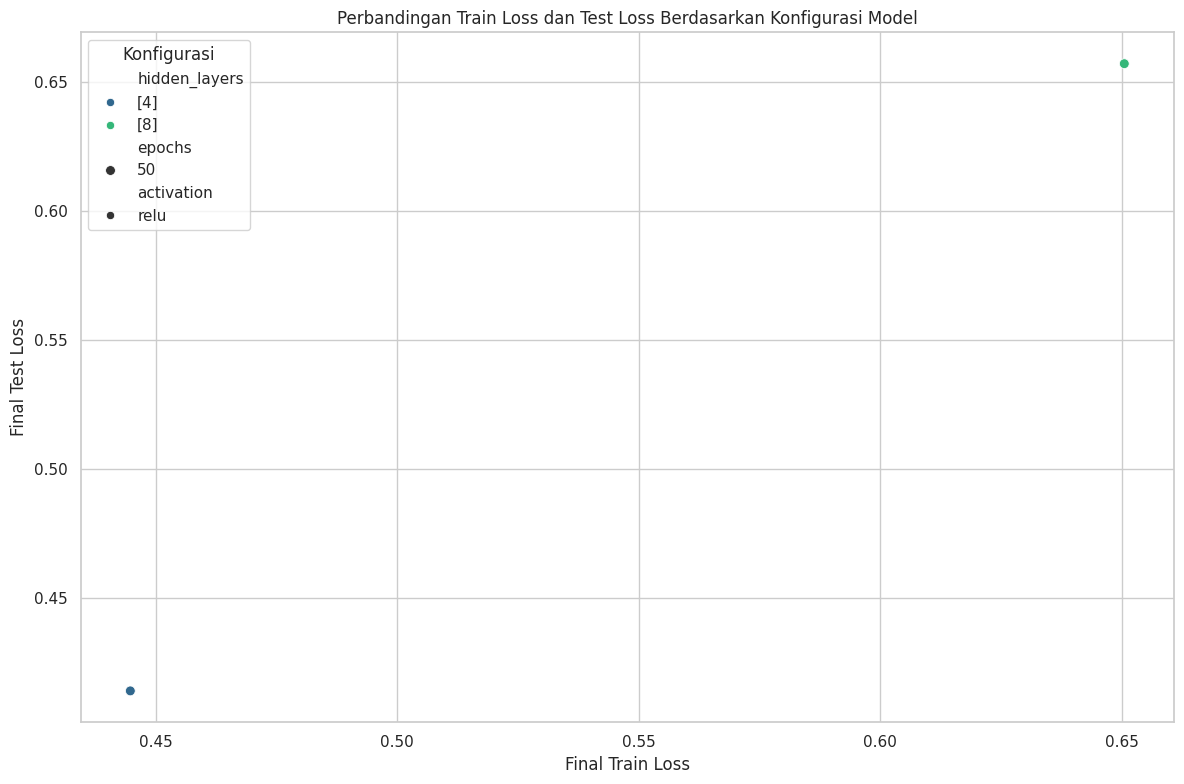

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Fungsi untuk mengubah 'hidden_layers' menjadi string agar bisa diproses dengan baik oleh Seaborn
def preprocess_results(results_df):
    # Mengubah 'hidden_layers' menjadi string
    results_df['hidden_layers'] = results_df['hidden_layers'].apply(lambda x: str(x))
    return results_df

# Fungsi untuk visualisasi hasil eksperimen
def plot_experiment_results(results_df):
    # Proses data untuk memastikan tidak ada tipe list di dalam 'hidden_layers'
    results_df = preprocess_results(results_df)

    # Mengatur tampilan grafik
    plt.figure(figsize=(12, 8))

    # Plot perbandingan Train Loss dan Test Loss
    sns.scatterplot(
        x='final_train_loss', y='final_test_loss',
        hue='hidden_layers', style='activation',
        size='epochs', sizes=(50, 200), data=results_df,
        palette='viridis', markers=["o", "s", "D", "P"]
    )

    # Menambahkan judul dan label sumbu
    plt.title('Perbandingan Train Loss dan Test Loss Berdasarkan Konfigurasi Model')
    plt.xlabel('Final Train Loss')
    plt.ylabel('Final Test Loss')

    # Menampilkan legenda
    plt.legend(title="Konfigurasi")

    # Menampilkan plot
    plt.tight_layout()
    plt.show()

# Menampilkan hasil eksperimen dengan scatter plot
plot_experiment_results(results_df)


**1. Analisis**

Pada eksperimen ini, kita menguji berbagai konfigurasi MLP Regression untuk memahami bagaimana pengaruh dari berbagai parameter seperti jumlah hidden layers, fungsi aktivasi, jumlah epoch, learning rate, dan batch size terhadap performa model. Dataset yang digunakan adalah dataset wine quality, yang dipecah menjadi data pelatihan dan data pengujian. Hasil eksperimen disimpan dalam bentuk CSV dan divisualisasikan untuk mempermudah analisis lebih lanjut.

**2. Insight**

Jumlah Hidden Layers & Neuron: Menambahkan lebih banyak hidden layers atau neuron tidak selalu memperbaiki performa. Terkadang model dengan lebih sedikit layers atau neuron memberikan hasil yang lebih baik karena kompleksitas model yang terlalu tinggi bisa menyebabkan overfitting.

Fungsi Aktivasi: Fungsi aktivasi seperti ReLU seringkali memberikan hasil terbaik pada model regresi, karena lebih efisien dalam memperkenalkan non-linearitas tanpa masalah vanishing gradient. Fungsi Sigmoid dan Softmax kurang cocok untuk regresi.

Epochs & Learning Rate: Terlalu sedikit epoch dapat menyebabkan model underfitting, sementara epoch terlalu banyak dengan learning rate yang besar bisa menyebabkan overfitting. Learning rate yang kecil lebih stabil, tapi memerlukan lebih banyak epoch.

Batch Size: Penggunaan batch size kecil lebih sering memberikan konvergensi yang lebih baik dan lebih cepat, tetapi lebih rentan terhadap noise pada data.

**3. Kesimpulan**

Eksperimen ini menunjukkan bahwa model MLP Regression cukup sensitif terhadap pemilihan parameter. ReLU adalah pilihan terbaik untuk fungsi aktivasi dalam regresi, dan epoch serta learning rate harus disesuaikan dengan bijak untuk menghindari overfitting atau underfitting. Pemilihan hidden layers dan neuron juga mempengaruhi performa model, namun jumlah yang lebih banyak tidak selalu memberikan hasil yang lebih baik. Batch size kecil sering kali menghasilkan pelatihan yang lebih baik dalam waktu yang lebih singkat.